# Evaluation of results

In [63]:
import numpy as np
from scipy.optimize import minimize
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
import glob
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

## Results Using pix2pix

In [64]:
imgname = '890.jpg'
infold = '../outputs/test/images/input/'
otfold = '../outputs/test/images/output/'
trfold = '../outputs/test/images/target/'

In [65]:
temp_in = img.imread(''.join((infold, imgname)))
temp_out = img.imread(''.join((otfold, imgname)))
temp_tar = img.imread(''.join((trfold, imgname)))

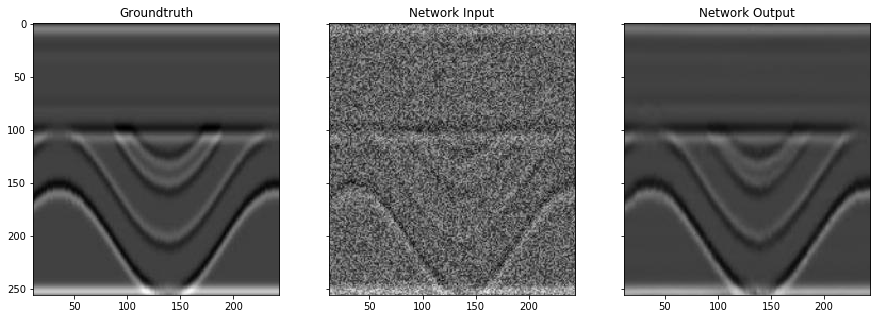

In [60]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

ax1.imshow(temp_tar, cmap='Greys')
ax1.set_title('Groundtruth')
ax2.imshow(temp_in, cmap='Greys')
ax2.set_title('Network Input')
ax3.imshow(temp_out, cmap='Greys')
ax3.set_title('Network Output')

plt.savefig('network_output.png', bbox_inches='tight')

## Comparison with other denoising strategies

In [66]:
%%time

tv = denoise_tv_chambolle(temp_in, weight=0.1, multichannel=True)
bilat = denoise_bilateral(temp_in, sigma_color=0.05, sigma_spatial=15,
                multichannel=True)
wavelet = denoise_wavelet(temp_in, multichannel=True)

CPU times: user 10.1 s, sys: 8 ms, total: 10.1 s
Wall time: 10.1 s


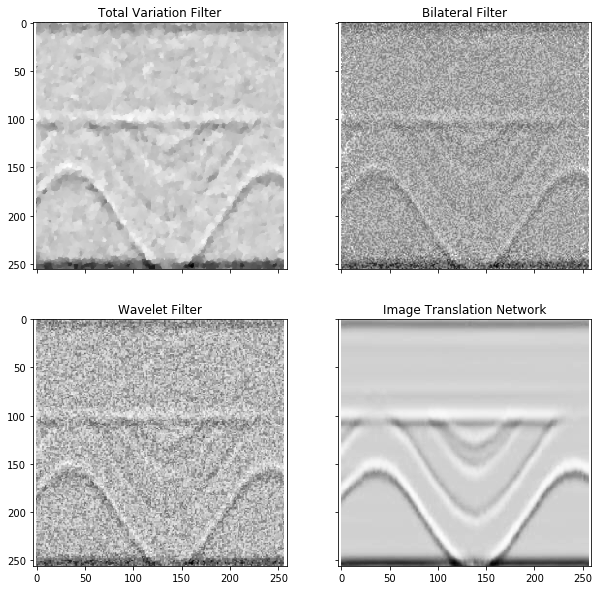

In [67]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))

ax1.imshow(tv[:,:,0], cmap='Greys')
ax1.set_title('Total Variation Filter')
ax2.imshow(bilat[:,:,0], cmap='Greys')
ax2.set_title('Bilateral Filter')
ax3.imshow(wavelet[:,:,0], cmap='Greys')
ax3.set_title('Wavelet Filter')
ax4.imshow(temp_out[:,:,0], cmap='Greys')
ax4.set_title('Image Translation Network')

plt.savefig('loss_comparison.png', bbox_inches='tight')

## Loss calculation

In [10]:
%%time

losses = []
outnames = glob.glob(''.join((otfold, '/*')))
tarnames = glob.glob(''.join((trfold, '/*')))

loss = lambda x, y : np.sum(abs(x-y))

for i in range(len(outnames)):
    target = img.imread(tarnames[i])[:,:,0]
    output = img.imread(outnames[i])[:,:,0]
    
    target = (target - target.min()) / target.max()
    output = (output - output.min()) / output.max()

    tv = denoise_tv_chambolle(temp_in, weight=0.1, multichannel=True)[:,:,0]
    bilat = denoise_bilateral(temp_in, sigma_color=0.05, sigma_spatial=15,
                multichannel=True)[:,:,0]
    wavelet = denoise_wavelet(temp_in, multichannel=True)[:,:,0]
    
    losses.append([loss(target, output), loss(target, tv), loss(target, bilat), loss(target, wavelet)])

CPU times: user 59min 33s, sys: 2.58 s, total: 59min 36s
Wall time: 59min 35s


In [18]:
with open('losses.csv', 'w') as f:
    f.write('pix2pix, tv, bilat, wavelet\n')
    for item in losses:
        for num in item:
            f.write('%s, ' % num)
        f.write('\n')

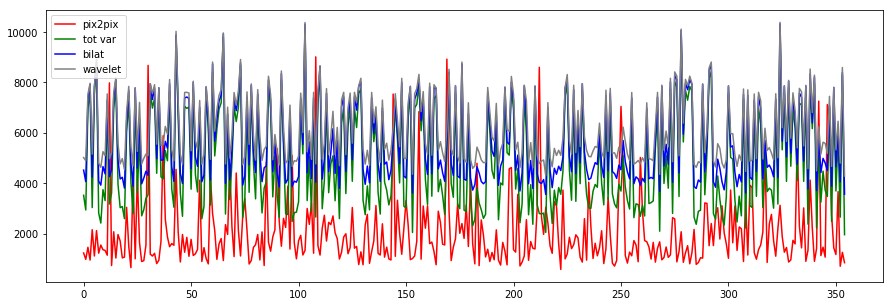

In [35]:
plt.figure(figsize=(15,5))

plt.plot(loss_array[:,0], 'red', label='pix2pix')
plt.plot(loss_array[:,1], 'green', label='tot var')
plt.plot(loss_array[:,2], 'blue', label='bilat')
plt.plot(loss_array[:,3], 'grey', label='wavelet')

plt.legend()
plt.show()

In [26]:
loss_array = np.asarray(losses)
ave_loss = np.mean(loss_array, axis=0)
std_loss = np.std(loss_array, axis=0)

print('pix2pix average loss = ', ave_loss[0], ', with standard deviation = ', std_loss[0])
print('tot var average loss = ', ave_loss[1], ', with standard deviation = ', std_loss[1])
print('bilat   average loss = ', ave_loss[2], ', with standard deviation = ', std_loss[2])
print('wavelet average loss = ', ave_loss[3], ', with standard deviation = ', std_loss[3])

pix2pix average loss =  2059.90603412 , with standard deviation =  1456.58066117
tot var average loss =  4909.50718026 , with standard deviation =  1996.23912034
bilat   average loss =  5657.25252955 , with standard deviation =  1629.81982228
wavelet average loss =  6167.8418937 , with standard deviation =  1365.77241086


In [50]:
print('Tot var has', np.round(ave_loss[1] / ave_loss[0] * 100), '% more loss than pix2pix.')
print('Bilat has', np.round(ave_loss[2] / ave_loss[0] * 100), '% more loss than pix2pix.')
print('Wavelet has', np.round(ave_loss[3] / ave_loss[0] * 100), '% more loss than pix2pix.')

Tot var has 238.0 % more loss than pix2pix.
Bilat has 275.0 % more loss than pix2pix.
Wavelet has 299.0 % more loss than pix2pix.


In [53]:
print('Tot var has', 10 * np.log10(ave_loss[1]/ave_loss[0]), 'dB more loss than pix2pix.')
print('Bilat has', 10 * np.log10(ave_loss[2]/ave_loss[0]), 'dB more loss than pix2pix.')
print('Wavelet has', 10 * np.log10(ave_loss[3]/ave_loss[0]), 'dB more loss than pix2pix.')

Tot var has 3.7719048974 dB more loss than pix2pix.
Bilat has 4.38758155506 dB more loss than pix2pix.
Wavelet has 4.76285822703 dB more loss than pix2pix.
